In [251]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
pd.options.display.float_format = '{:.2f}'.format

In [252]:
penetration_data = pd.read_excel('SVODpenetration.xlsx')
revenue_data = pd.read_excel('SVODrevenue.xlsx',  thousands=',')
gdp_data = pd.read_excel('GDP Data.xlsx')
mass_data = pd.read_excel("Lots of Country Data.xlsx")
o_unemployment_data = pd.read_csv("Unemployment Stats.csv",)

In [253]:
unemployment_data = o_unemployment_data.set_index('Country')
unemployment_data = unemployment_data.replace('---', np.nan)
unemployment_data = unemployment_data.apply(pd.to_numeric)
unemployment_data['Average Rate'] = (unemployment_data['unemploymentByCountry_rateCia']+unemployment_data['unemploymentByCountry_rateIlo']+unemployment_data['unemploymentByCountry_rateWb'])/3
unemployment_data['Average Rate'] = unemployment_data['Average Rate'].fillna(unemployment_data['Average Rate'].mean())

In [254]:
grouped_mass = mass_data.groupby('Series Name')
grouped_df = pd.DataFrame()
for name, group in grouped_mass:
    grouped_df[name] = group['2022 [YR2022]'].values
grouped_df = grouped_df.replace('..', np.nan)
grouped_df = grouped_df.replace('...', np.nan)
grouped_df = grouped_df.apply(pd.to_numeric)
grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 6 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   Individuals using the Internet (% of population)                  57 non-null     float64
 1   Inflation, GDP deflator (annual %)                                185 non-null    float64
 2   Inflation, consumer prices (annual %)                             161 non-null    float64
 3   Population, total                                                 217 non-null    int64  
 4   Secure Internet servers (per 1 million people)                    0 non-null      float64
 5   Unemployment, total (% of total labor force) (national estimate)  73 non-null     float64
dtypes: float64(5), int64(1)
memory usage: 10.3 KB


In [255]:
new_penetration_data = penetration_data.set_index('Country').loc[:,"2023"]
new_revenue_data = revenue_data.set_index('Country').loc[:,"2023"]
new_gdp_data = gdp_data.set_index('Country').loc[:,"2022 [YR2022]"]

In [256]:
new_gdp_data = new_gdp_data.replace('..', np.nan)
new_gdp_data = new_gdp_data.replace('...', np.nan)
new_gdp_data = new_gdp_data.apply(pd.to_numeric)
new_gdp_data = np.log(new_gdp_data)
new_gdp_data = new_gdp_data.fillna(new_gdp_data.mean())


In [257]:
lf = pd.concat([new_penetration_data, new_revenue_data, new_gdp_data, unemployment_data["Average Rate"], unemployment_data['pop2023']], axis=1, join='inner', keys=['Penetration', 'Revenue', 'GDP', 'Unemployment Rate', 'Population'])
df = lf.copy()
df['Penetration_Heuristic'] = 4/np.log(1+df['Penetration']) # Heuristic function for the percentage growth of penetration that we expect to see
df.sort_values(by = ['Unemployment Rate'], ascending=False)[:15]

,Penetration,Revenue,GDP,Unemployment Rate,Population,Penetration_Heuristic
Country,,,,,,
South Africa,12.40,220.20,26.73,28.98,60414495,1.54
Burkina Faso,6.90,9.32,23.66,28.80,23251485,1.94
Namibia,14.10,5.01,23.26,24.60,2604172,1.47
Lesotho,9.20,4.10,21.66,24.30,2330318,1.72
Botswana,9.70,4.06,23.74,22.50,2675352,1.69
Bosnia and Herzegovina,6.90,9.21,23.92,21.63,3210847,1.94
Armenia,12.80,8.04,23.69,18.50,2777970,1.52
Senegal,8.60,17.55,24.04,18.17,17763163,1.77
Jordan,10.10,19.23,24.58,17.57,11337052,1.66


The function 5/np.log(1+df['Penetration']) is representative of the rate of growth we can expect the market to grow as it is easier for penetration to go up the lower it already is. It is scaled to be more realistic by a factor of 10.

In [258]:
scaler = MinMaxScaler()
df[['GDP', 'Penetration', 'Unemployment Rate', "Population",'Revenue']] = scaler.fit_transform(df[['GDP', 'Penetration', 'Unemployment Rate', "Population", 'Revenue']])
# pca_econ_stability= PCA(n_components=1)
# pca_market_size = PCA(n_components=1)
# df['Econ Stability Index'] = pca_econ_stability.fit_transform(df[['GDP', 'Unemployment Rate']])
# df['Market Size Index'] = pca_market_size.fit_transform(df[['Revenue', 'Population']])

df['Econ Stability Index'] = df['GDP'] - df['Unemployment Rate']
df['Market Size Index'] = df['Revenue'] + df['Population']
df['Econ Stability Index'] = scaler.fit_transform(df[['Econ Stability Index']])
df['Market Size Index'] = scaler.fit_transform(df[['Market Size Index']])
df['Penetration_Heuristic'] = scaler.fit_transform(df[['Penetration_Heuristic']])
df['Index'] = df['Econ Stability Index'] + 2*df['Market Size Index'] + df['Penetration_Heuristic']/2
df['Index'] = scaler.fit_transform(df[['Index']])

In [259]:
df.sort_values(by = ['Index'], ascending=False).query('GDP > 0.5')[:50]

,Penetration,Revenue,GDP,Unemployment Rate,Population,Penetration_Heuristic,Econ Stability Index,Market Size Index,Index
Country,,,,,,,,,
China,0.57,0.49,0.96,0.15,1.00,0.10,1.00,1.00,1.00
United States,1.00,1.00,1.00,0.22,0.24,0.00,0.98,0.83,0.85
India,0.04,0.04,0.79,0.20,1.00,0.75,0.86,0.70,0.85
Indonesia,0.07,0.01,0.69,0.14,0.19,0.62,0.83,0.14,0.42
Bangladesh,0.02,0.00,0.59,0.14,0.12,0.84,0.77,0.08,0.40
Mexico,0.08,0.01,0.70,0.13,0.09,0.59,0.85,0.07,0.37
Pakistan,0.10,0.01,0.56,0.15,0.17,0.54,0.75,0.12,0.36
Philippines,0.05,0.00,0.57,0.10,0.08,0.70,0.79,0.06,0.36
Thailand,0.08,0.00,0.59,0.01,0.05,0.59,0.85,0.04,0.35


In [265]:
lf['Index'] = df['Index']
lf['Econ Stability Index'] = df['Econ Stability Index']
lf['Market Size Index'] = df['Market Size Index']
lf.sort_values(by = ['Index'], ascending=False).query('GDP > 26.5')[:50]

,Penetration,Revenue,GDP,Unemployment Rate,Population,Index,Econ Stability Index,Market Size Index
Country,,,,,,,,
China,28.30,19360.00,30.52,4.68,1425671352,1.00,1.00,1.00
United States,46.70,39250.00,30.87,6.70,339996563,0.85,0.98,0.83
India,5.60,1696.00,28.85,6.17,1428627663,0.85,0.86,0.70
Indonesia,6.90,302.60,27.91,4.64,277534122,0.42,0.83,0.14
Bangladesh,4.90,152.70,26.85,4.40,172954319,0.40,0.77,0.08
Mexico,7.30,550.00,27.98,4.16,128455567,0.37,0.85,0.07
Pakistan,8.10,293.20,26.65,4.73,240485658,0.36,0.75,0.12
Philippines,6.00,130.70,26.73,3.27,117337368,0.36,0.79,0.06
Thailand,7.30,190.00,26.93,0.93,71801279,0.35,0.85,0.04


In [232]:
import seaborn as sns

<Axes: xlabel='Index', ylabel='Country'>

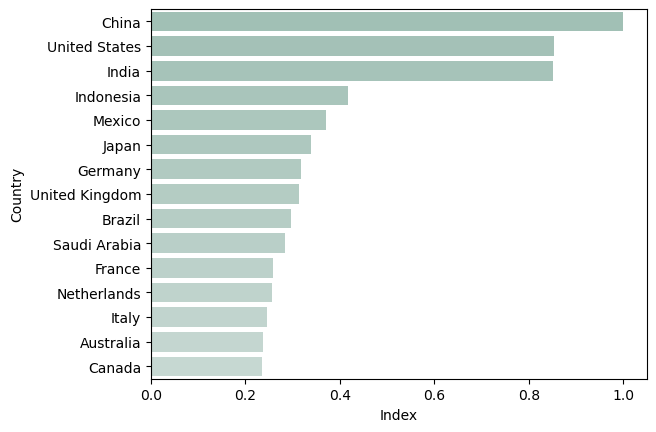

In [264]:
sns.barplot(y=lf.sort_values(by = ['Index'], ascending=False).query('GDP > 27')[:15].index, 
            x=lf.sort_values(by = ['Index'], ascending=False).query('GDP > 27')[:15]['Index'], 
            palette=sns.light_palette("#9cc5b7", n_colors=30, reverse=True))